In [1]:
import pandas as pd
import numpy as np
import itertools as it
import functools as ft
import multiprocessing as mp

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model.coordinate_descent import LinearModelCV
from sklearn.linear_model import ElasticNetCV
from sklearn.base import RegressorMixin
from sklearn.model_selection import cross_validate
from sklearn.metrics import *

from tools import helpers as h

from scipy.stats import norm

%matplotlib inline
import matplotlib.pyplot as plt

### Read in Louvain Subclusters

In [2]:
louv = pd.read_csv('../results/networkClusters/louvain_clusters.txt', index_col=0, sep='\t')
louv.columns = ['cluster_super']
louv = louv.merge(pd.read_csv('../results/networkClusters/louvain_small_clusters.txt', index_col=0, sep='\t'), left_index=True, right_index=True)
louv.columns = ['cluster_super', 'cluster_sub']
louv.head()

,cluster_super,cluster_sub
names,,
MST1R,3,11
YES1,3,11
TYRO3,3,11
FGR,3,11
SRC,3,11


### Get the HGNC Mapper

In [4]:
hgnc_mapper = h.fetch_hgnc_mapper(path_to_hgnc='../data/miscReference/hgnc_alias_list.txt',
                                 path_to_kmast='../data/miscReference/KINASESmasterlist_w_Aliases.xlsx')

In [5]:
def splitDataFrameList(df,target_column,separator):
    ''' df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    def splitListToRows(row,row_accumulator,target_column,separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)
    new_rows = []
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,separator))
    new_df = pd.DataFrame(new_rows)
    return new_df

### Klaeger Science Data

In [6]:
# initial target list -- not for linear programming
klaeger = pd.read_excel('../data/KlaegerScience2017/Klaeger_Science_2017 Supplementary Table 2 Target Lists.xlsx', sheet_name='Kinobeads')

# a number of drugs have very similar targets listed in the same row
# we parse to separate these out 
klaeger = splitDataFrameList(klaeger, 'Gene Name', ';')
# filter to only hgnc keys
klaeger = klaeger[klaeger['Gene Name'].isin(hgnc_mapper.keys())]

# convert to hgnc
klaeger['Gene Name'] = klaeger['Gene Name'].apply(lambda x: hgnc_mapper[x])

# filter to our kinases
klaeger = klaeger[klaeger['Gene Name'].isin(set(louv.index))]

# lower drug names
klaeger['Drug'] = [x.lower().replace('-', '') for x in klaeger.Drug]

klaeger.head()

,Apparent Kd,BIC,Beads,Bottom,Correction Factor,DMSO Intensity,Drug,EC50,EC50 Standard Error,Gene Name,...,Relative Intensity 1000 nM,Relative Intensity 3 nM,Relative Intensity 30 nM,Relative Intensity 300 nM,Relative Intensity 3000 nM,Relative Intensity 30000 nM,Relative Intensity DMSO,Slope,Target Classification,Top
0,101.828368,-20.503519,Kinobeads,0.009092,0.673073,136300000,abemaciclib,151.288760,45.696999,AAK1,...,0.181984,0.905556,0.738292,0.323354,0.063421,0.057103,1,0.773714,High confidence,0.957905
1,39.805937,-12.606135,Kinobeads,-0.001200,0.622595,10460000,abemaciclib,63.935536,68.832970,ADCK1,...,0.000000,1.045974,1.141565,0.000000,0.000000,0.000000,1,12.051439,High confidence,1.014355
2,56031.642989,-15.330485,Kinobeads,-1.003278,0.660952,72050000,abemaciclib,84774.108960,217756.243215,BMP2K,...,0.885498,1.101696,1.087891,0.863230,0.862572,0.313434,1,0.603088,High confidence,1.034558
3,19.447883,-22.486948,Kinobeads,0.018690,0.203913,888660000,abemaciclib,95.373379,12.131433,CAMK2D,...,0.021331,0.894551,0.900583,0.178266,0.004220,0.017424,1,1.774882,High confidence,0.972850
4,17.889794,1.734623,Kinobeads,0.043265,0.217204,266400000,abemaciclib,82.363844,NaN,CAMK2G,...,0.013431,1.125435,1.236451,0.139777,0.005382,0.017473,1,6.255996,High confidence,1.232332


In [7]:
len(set(klaeger.Drug))

220

In [8]:
len(set(klaeger['Gene Name']))

247

In [9]:
raw_conc_data = klaeger[['Drug', 'Gene Name'] + [x for x in klaeger.columns if 'Relative Intensity' in x and 'DMSO' not in x]]
raw_conc_data.head()

,Drug,Gene Name,Relative Intensity 10 nM,Relative Intensity 100 nM,Relative Intensity 1000 nM,Relative Intensity 3 nM,Relative Intensity 30 nM,Relative Intensity 300 nM,Relative Intensity 3000 nM,Relative Intensity 30000 nM
0,abemaciclib,AAK1,0.791054,0.639565,0.181984,0.905556,0.738292,0.323354,0.063421,0.057103
1,abemaciclib,ADCK1,0.869866,0.000000,0.000000,1.045974,1.141565,0.000000,0.000000,0.000000
2,abemaciclib,BMP2K,1.012297,0.973740,0.885498,1.101696,1.087891,0.863230,0.862572,0.313434
3,abemaciclib,CAMK2D,0.984481,0.440384,0.021331,0.894551,0.900583,0.178266,0.004220,0.017424
4,abemaciclib,CAMK2G,1.565245,0.315507,0.013431,1.125435,1.236451,0.139777,0.005382,0.017473


In [10]:
from numba import jit

#@jit()
def gr(conc, GRinf, GR50, GR_Hill_Coeff):
    return GRinf + np.divide(1- GRinf, 1 + np.power(np.divide(conc,GR50+1.e-20), GR_Hill_Coeff)+1.e-20)


def extract_metrics(df, molecule):
    # look for the molecule in the dataframe and extract the relevant items
    return df[df['molecule']==molecule]

### Examine Molecules

In [11]:
agg = pd.read_csv('../data/regressionInputs/input_grMetrics.tsv', sep='\t', header=0, index_col=None)

# filter to high r2 values
agg = agg[agg['GR_r2'] > .6]
agg.head()

,molecule,cellline,GR50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_r2,inf_50,missing_50,normal_50
0,seliciclib,bt20,1.898774,0.194160,-1.00000,1.17820,0.17548,0.97227,0.0,0.0,1.0
1,a443654,bt20,0.051675,-0.492210,-0.63357,0.55758,1.00120,0.98743,0.0,0.0,1.0
3,at7519,bt20,0.186015,-0.401780,-0.40563,1.32240,0.86351,0.99936,0.0,0.0,1.0
4,azd5438,bt20,0.219866,-0.354640,-0.44610,0.79155,0.74810,0.99091,0.0,0.0,1.0
5,azd6482,bt20,0.827110,-0.081485,-0.54825,0.76277,0.42682,0.99881,0.0,0.0,1.0


In [12]:
# filter out nans
agg = agg[agg['GR50'] > 0]

### Begin Merging
#### update: now we don't cut the small moledcules missing

In [13]:
display(len(set(agg.molecule)& set(klaeger.Drug)))
display(len(set(agg.molecule) & set(raw_conc_data.Drug)))

82

82

In [15]:
common_drugs = set(agg.molecule) & set(raw_conc_data.Drug)

In [17]:
#agg = agg[agg.molecule.isin(common_drugs)]
agg['Shared'] = agg.molecule.isin(common_drugs)
conc_data = raw_conc_data.copy()
conc_data['Shared'] = conc_data.Drug.isin(common_drugs)

conc_data.head()

,Drug,Gene Name,Relative Intensity 10 nM,Relative Intensity 100 nM,Relative Intensity 1000 nM,Relative Intensity 3 nM,Relative Intensity 30 nM,Relative Intensity 300 nM,Relative Intensity 3000 nM,Relative Intensity 30000 nM,Shared
0,abemaciclib,AAK1,0.791054,0.639565,0.181984,0.905556,0.738292,0.323354,0.063421,0.057103,False
1,abemaciclib,ADCK1,0.869866,0.000000,0.000000,1.045974,1.141565,0.000000,0.000000,0.000000,False
2,abemaciclib,BMP2K,1.012297,0.973740,0.885498,1.101696,1.087891,0.863230,0.862572,0.313434,False
3,abemaciclib,CAMK2D,0.984481,0.440384,0.021331,0.894551,0.900583,0.178266,0.004220,0.017424,False
4,abemaciclib,CAMK2G,1.565245,0.315507,0.013431,1.125435,1.236451,0.139777,0.005382,0.017473,False


In [38]:
#conc_data[conc_data.isna().any(axis=1)]
np.sum(conc_data.isna())

Drug                            0
Gene Name                       0
Relative Intensity 10 nM       50
Relative Intensity 100 nM      18
Relative Intensity 1000 nM     54
Relative Intensity 3 nM         0
Relative Intensity 30 nM        9
Relative Intensity 300 nM       9
Relative Intensity 3000 nM      4
Relative Intensity 30000 nM     0
Shared                          0
dtype: int64

In [66]:
#raw_conc_data.to_csv('../data/regressionInputs/rawConcentrationData', sep='\t')
conc_data = raw_conc_data.melt(id_vars=['Drug', 'Gene Name'], 
                   value_vars=['Relative Intensity 10 nM',
                              'Relative Intensity 100 nM',
                              'Relative Intensity 3 nM',
                              'Relative Intensity 30 nM',
                              'Relative Intensity 300 nM',
                              'Relative Intensity 1000 nM',
                              'Relative Intensity 3000 nM',
                              'Relative Intensity 10000 nM',
                              'Relative Intensity 30000 nM'
                                ])
conc_data.columns = ['Drug', 'Gene', 'Concentration', 'Value']
conc_data = conc_data.pivot_table(index=['Drug', 'Concentration'], columns='Gene').fillna(1.0)

conc_data.head()

Value                         \
Gene                                        AAK1 ABL1 ABL2 ACVR1 ACVR1B   
Drug        Concentration                                                 
abemaciclib Relative Intensity 10 nM    0.791054  1.0  1.0   1.0    1.0   
            Relative Intensity 100 nM   0.639565  1.0  1.0   1.0    1.0   
            Relative Intensity 1000 nM  0.181984  1.0  1.0   1.0    1.0   
            Relative Intensity 3 nM     0.905556  1.0  1.0   1.0    1.0   
            Relative Intensity 30 nM    0.738292  1.0  1.0   1.0    1.0   

                                                                         ...   \
Gene                                   ACVR2B ACVRL1     ADCK1  ADK  AK2 ...    
Drug        Concentration                                                ...    
abemaciclib Relative Intensity 10 nM      1.0    1.0  0.869866  1.0  1.0 ...    
            Relative Intensity 100 nM     1.0    1.0  0.000000  1.0  1.0 ...    
            Relative Intensity 1000 nM    1.0    1.0  0.000000  1.0  1.0 ...    
            Relative Intensity 3 nM       1.0    1.0  1.045974  1.0  1.0 ...    
            Relative Intensity 30 nM      1.0    1.0  1.141565  1.0  1.0 ...    

                                                                               \
Gene                                   TGFBR2 TNIK TNK1 TNK2 TP53RK  TTK TYK2   
Drug        Concentration                                                       
abemaciclib Relative Intensity 10 nM      1.0  1.0  1.0  1.0    1.0  1.0  1.0   
            Relative Intensity 100 nM     1.0  1.0  1.0  1.0    1.0  1.0  1.0   
            Relative Intensity 1000 nM    1.0  1.0  1.0  1.0    1.0  1.0  1.0   
            Relative Intensity 3 nM       1.0  1.0  1.0  1.0    1.0  1.0  1.0   
            Relative Intensity 30 nM      1.0  1.0  1.0  1.0    1.0  1.0  1.0   

                                                       
Gene                                   ULK1 WEE1 YES1  
Drug        Concentration                              
abemaciclib Relative Intensity 10 nM    1.0  1.0  1.0  
            Relative Intensity 100 nM   1.0  1.0  1.0  
            Relative Intensity 1000 nM  1.0  1.0  1.0  
            Relative Intensity 3 nM     1.0  1.0  1.0  
            Relative Intensity 30 nM    1.0  1.0  1.0  

[5 rows x 247 columns]

In [58]:
conc_data.shape

(1752, 247)

In [63]:
# this gives us an idea of the sensitivity of the kinobeads
# we can use this to avoid - infinity after a log2 transform
min_observed = conc_data[conc_data > 0].min().min()

### Here we translate 0 intensities to a very small intensity

In [70]:
# min_cutter = 2 assumes machine precision half of smallest
min_cutter = 2

# fill the zeros with the precision
conc_data = conc_data.replace(0, min_observed/min_cutter) 

# verify the min is nonzero
conc_data.min().min()

0.000240893135725429

In [73]:
# log2 transform the data
conc_data = conc_data.apply(np.log2)
conc_data.head()

Value                         \
Gene                                        AAK1 ABL1 ABL2 ACVR1 ACVR1B   
Drug        Concentration                                                 
abemaciclib Relative Intensity 10 nM   -0.338152  0.0  0.0   0.0    0.0   
            Relative Intensity 100 nM  -0.644837  0.0  0.0   0.0    0.0   
            Relative Intensity 1000 nM -2.458113  0.0  0.0   0.0    0.0   
            Relative Intensity 3 nM    -0.143124  0.0  0.0   0.0    0.0   
            Relative Intensity 30 nM   -0.437736  0.0  0.0   0.0    0.0   

                                                                           \
Gene                                   ACVR2B ACVRL1      ADCK1  ADK  AK2   
Drug        Concentration                                                   
abemaciclib Relative Intensity 10 nM      0.0    0.0  -0.201136  0.0  0.0   
            Relative Intensity 100 nM     0.0    0.0 -12.019319  0.0  0.0   
            Relative Intensity 1000 nM    0.0    0.0 -12.019319  0.0  0.0   
            Relative Intensity 3 nM       0.0    0.0   0.064847  0.0  0.0   
            Relative Intensity 30 nM      0.0    0.0   0.191013  0.0  0.0   

                                       ...                                     \
Gene                                   ...  TGFBR2 TNIK TNK1 TNK2 TP53RK  TTK   
Drug        Concentration              ...                                      
abemaciclib Relative Intensity 10 nM   ...     0.0  0.0  0.0  0.0    0.0  0.0   
            Relative Intensity 100 nM  ...     0.0  0.0  0.0  0.0    0.0  0.0   
            Relative Intensity 1000 nM ...     0.0  0.0  0.0  0.0    0.0  0.0   
            Relative Intensity 3 nM    ...     0.0  0.0  0.0  0.0    0.0  0.0   
            Relative Intensity 30 nM   ...     0.0  0.0  0.0  0.0    0.0  0.0   

                                                            
Gene                                   TYK2 ULK1 WEE1 YES1  
Drug        Concentration                                   
abemaciclib Relative Intensity 10 nM    0.0  0.0  0.0  0.0  
            Relative Intensity 100 nM   0.0  0.0  0.0  0.0  
            Relative Intensity 1000 nM  0.0  0.0  0.0  0.0  
            Relative Intensity 3 nM     0.0  0.0  0.0  0.0  
            Relative Intensity 30 nM    0.0  0.0  0.0  0.0  

[5 rows x 247 columns]

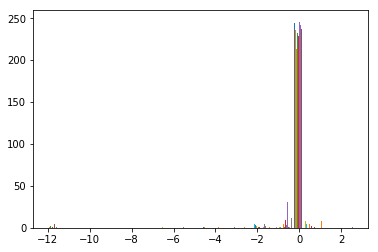

In [75]:
plt.hist(conc_data.sample(frac=.05), bins=30)
plt.show()

In [89]:
conc_data.index.get_level_values(1)

Index(['Relative Intensity 10 nM', 'Relative Intensity 100 nM',
       'Relative Intensity 1000 nM', 'Relative Intensity 3 nM',
       'Relative Intensity 30 nM', 'Relative Intensity 300 nM',
       'Relative Intensity 3000 nM', 'Relative Intensity 30000 nM',
       'Relative Intensity 10 nM', 'Relative Intensity 100 nM',
       ...
       'Relative Intensity 3000 nM', 'Relative Intensity 30000 nM',
       'Relative Intensity 10 nM', 'Relative Intensity 100 nM',
       'Relative Intensity 1000 nM', 'Relative Intensity 3 nM',
       'Relative Intensity 30 nM', 'Relative Intensity 300 nM',
       'Relative Intensity 3000 nM', 'Relative Intensity 30000 nM'],
      dtype='object', name='Concentration', length=1752)

In [105]:
# first, convert concentration to micromolar (numeric)
conc_data.index = conc_data.index.set_levels(conc_data.index.levels[1].to_series().apply(lambda x: float(x.split(' ')[2]))/1000., level=1)

conc_data.head()

Value                                       \
Gene                           AAK1 ABL1 ABL2 ACVR1 ACVR1B ACVR2B ACVRL1   
Drug        Concentration                                                  
abemaciclib 0.010         -0.338152  0.0  0.0   0.0    0.0    0.0    0.0   
            0.100         -0.644837  0.0  0.0   0.0    0.0    0.0    0.0   
            1.000         -2.458113  0.0  0.0   0.0    0.0    0.0    0.0   
            0.003         -0.143124  0.0  0.0   0.0    0.0    0.0    0.0   
            0.030         -0.437736  0.0  0.0   0.0    0.0    0.0    0.0   

                                               ...                         \
Gene                           ADCK1  ADK  AK2 ...  TGFBR2 TNIK TNK1 TNK2   
Drug        Concentration                      ...                          
abemaciclib 0.010          -0.201136  0.0  0.0 ...     0.0  0.0  0.0  0.0   
            0.100         -12.019319  0.0  0.0 ...     0.0  0.0  0.0  0.0   
            1.000         -12.019319  0.0  0.0 ...     0.0  0.0  0.0  0.0   
            0.003           0.064847  0.0  0.0 ...     0.0  0.0  0.0  0.0   
            0.030           0.191013  0.0  0.0 ...     0.0  0.0  0.0  0.0   

                                                           
Gene                      TP53RK  TTK TYK2 ULK1 WEE1 YES1  
Drug        Concentration                                  
abemaciclib 0.010            0.0  0.0  0.0  0.0  0.0  0.0  
            0.100            0.0  0.0  0.0  0.0  0.0  0.0  
            1.000            0.0  0.0  0.0  0.0  0.0  0.0  
            0.003            0.0  0.0  0.0  0.0  0.0  0.0  
            0.030            0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 247 columns]

### Calculate the growth for each (drug, concentration)

In [107]:
from time import time
s = time()
interpolated_data = {}
concentrations = list(conc_data.index.levels[1].unique())
drugs_pres = common_drugs

count = 0
# loop through the observations and create new data
for d in drugs_pres:
    # select observed data
    gr_data_to_interpolate_with = extract_metrics(agg, d)
    
    for i, gr_row in gr_data_to_interpolate_with.iterrows():
        local_gr50, local_grinf, local_grhill, local_cellline = list(gr_row[['GR50', 'GRinf', 'GR_Hill_Coeff', 'cellline']].values)
        
        for c in concentrations:
            interpolated_data[(d, local_cellline, c)] = gr(c, local_grinf, local_gr50, local_grhill)
        
    if count % 10 == 0: 
        print('Done with combo '  + str(count) + '/' + str(len(drugs_pres)))
    count +=1
print(time()-s)

Done with combo 0/82
Done with combo 10/82
Done with combo 20/82
Done with combo 30/82
Done with combo 40/82
Done with combo 50/82
Done with combo 60/82
Done with combo 70/82
Done with combo 80/82
8.329766750335693


In [112]:
interpolated_df = pd.DataFrame(pd.Series(interpolated_data))
interpolated_df.head()

0
gsk1070916 184a1 0.010  0.880238
                 0.100  0.545189
                 1.000 -0.109431
                 0.003  0.944885
                 0.030  0.765498

In [115]:
from umap import UMAP

In [121]:
conc_data.shape

(1752, 247)

In [122]:
# fig, ax = plt.subplots(figsize=(12,10))
# u = UMAP(metric='cosine')
# uspace = u.fit_transform(conc_data.values)
# ax.scatter(uspace[:, 0], uspace[:, 1])
# plt.show()

In [178]:
interpolated_df = interpolated_df.reset_index()
interpolated_df.columns = ['Drug', 'Cellline', 'Concentration', 'Growth']

conc_data = conc_data.reset_index()

interpolated_df['idx'] = interpolated_df['Drug'] + interpolated_df['Concentration'].apply(str)
conc_data['idx'] = conc_data['Drug'] + conc_data['Concentration'].apply(str)

### TODO -- Inspect variable number of cell lines

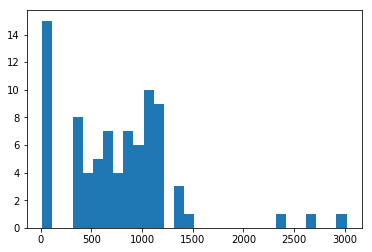

In [168]:
plt.hist(interpolated_df.groupby(['Drug'])['Cellline'].count(), bins=30)
plt.show()

In [182]:
reduced_interpolated_df = interpolated_df.groupby(['Drug', 'Concentration', 'idx'])['Growth'].agg(np.mean).reset_index()

In [193]:
# convert conc data columns from multindex (result of pivot)
conc_data.columns = conc_data.columns.droplevel(0)
conc_data.columns = ['Drug', 'Concentration'] + list(conc_data.columns[2:])

# merge left the mean values per cell line onto conc_data
merged_df = conc_data.merge(reduced_interpolated_df,
                            how='left', on='idx').drop('idx', axis=1)

merged_df = merged_df[list(merged_df.columns[:2]) + ['Growth'] + list(merged_df.columns[2:-4])]
merged_df.columns = ['Drug', 'Concentration', 'Growth'] + list(merged_df.columns[3:])
merged_df.head()

,Drug,Concentration,Growth,AAK1,ABL1,ABL2,ACVR1,ACVR1B,ACVR2B,ACVRL1,...,TGFBR2,TNIK,TNK1,TNK2,TP53RK,TTK,TYK2,ULK1,WEE1,YES1
0,abemaciclib,0.010,NaN,-0.338152,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,abemaciclib,0.100,NaN,-0.644837,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,abemaciclib,1.000,NaN,-2.458113,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,abemaciclib,0.003,NaN,-0.143124,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,abemaciclib,0.030,NaN,-0.437736,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [194]:
merged_df.shape

(1752, 250)

In [198]:
# standardize the columns
kin_standard_dev = merged_df.std(axis=0)[2:]
merged_df[merged_df.columns[3:]] /= kin_standard_dev

In [199]:
kin_standard_dev.to_csv('../data/kinase_standard_deviations.csv')
merged_df.to_csv('../data/target_concentration_data.csv', index=False)

In [200]:
merged_df.head()

,Drug,Concentration,Growth,AAK1,ABL1,ABL2,ACVR1,ACVR1B,ACVR2B,ACVRL1,...,TGFBR2,TNIK,TNK1,TNK2,TP53RK,TTK,TYK2,ULK1,WEE1,YES1
0,abemaciclib,0.010,NaN,-0.204882,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,abemaciclib,0.100,NaN,-0.390699,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,abemaciclib,1.000,NaN,-1.489340,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,abemaciclib,0.003,NaN,-0.086717,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,abemaciclib,0.030,NaN,-0.265219,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [205]:
merged_df.shape[0] //8

219

In [329]:
from sklearn.preprocessing import LabelEncoder
c = LabelEncoder().fit_transform(merged_df.Drug)
drug_ids = dict(zip(c,merged_df.Drug.tolist()))
growth = merged_df.Growth

umap_X = merged_df.drop(['Drug', 'Concentration', 'Growth'], axis=1)
hue = merged_df.Drug
print(umap_X.shape)
umap_X.head()

(1752, 247)


,AAK1,ABL1,ABL2,ACVR1,ACVR1B,ACVR2B,ACVRL1,ADCK1,ADK,AK2,...,TGFBR2,TNIK,TNK1,TNK2,TP53RK,TTK,TYK2,ULK1,WEE1,YES1
0,-0.204882,0.0,0.0,0.0,0.0,0.0,0.0,-0.134767,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.390699,0.0,0.0,0.0,0.0,0.0,0.0,-8.053322,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.489340,0.0,0.0,0.0,0.0,0.0,0.0,-8.053322,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.086717,0.0,0.0,0.0,0.0,0.0,0.0,0.043450,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.265219,0.0,0.0,0.0,0.0,0.0,0.0,0.127985,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [420]:
umap_X.head(1)

,AAK1,ABL1,ABL2,ACVR1,ACVR1B,ACVR2B,ACVRL1,ADCK1,ADK,AK2,...,TGFBR2,TNIK,TNK1,TNK2,TP53RK,TTK,TYK2,ULK1,WEE1,YES1
0,-0.204882,0.0,0.0,0.0,0.0,0.0,0.0,-0.134767,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [366]:
from umap import UMAP
from sklearn.manifold import Isomap
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics.pairwise import rbf_kernel

In [211]:
import seaborn as sns

In [418]:
u_drug = UMAP(metric='cosine', n_neighbors=100, min_dist=.25)
#u_drug = Isomap(n_neighbors=25)
#u_drug = SpectralEmbedding(n_neighbors=25)
 
u_coords = u_drug.fit_transform(umap_X)

In [335]:
plot_text = pd.DataFrame(u_coords)
plot_text['Drug'] = hue
plot_text.head()

,0,1,Drug
0,-0.205615,12.677481,abemaciclib
1,1.038930,8.320755,abemaciclib
2,0.915447,8.621326,abemaciclib
3,0.163162,9.906877,abemaciclib
4,0.429882,8.611157,abemaciclib


In [336]:
from scipy.spatial.distance import cdist
plot_text = plot_text.groupby('Drug').agg(np.mean)

# offset and separation
plot_text[0] = plot_text[0] + .01


plot_text.head()

,0,1
Drug,,
abemaciclib,0.661391,9.226273
ac480,-2.219829,1.559929
actb1003,3.068485,3.527209
aee788,1.546302,2.558313
aew541,3.831993,8.210786


In [337]:
to_fix = np.logical_and(cdist(plot_text.values, plot_text.values) < 1, cdist(np.expand_dims(plot_text[1].values, 1), np.expand_dims(plot_text[1].values,1)) < .2) * 1.
to_fix[np.diag_indices_from(to_fix)] = 0

print(np.sum(to_fix))

464.0


In [338]:
for x,y in zip(*np.where(to_fix)):
    if x < y:
        pass
    else:
        x_y_coord = plot_text.iloc[x, 1]
        y_y_coord = plot_text.iloc[y, 1]
        
        if x_y_coord > y_y_coord:
            plot_text.iloc[x, 1] = x_y_coord + .01
            plot_text.iloc[y, 1] = y_y_coord - .01
        else:
            plot_text.iloc[y, 1] = y_y_coord + .01
            plot_text.iloc[y, 1] = x_y_coord - .01
      

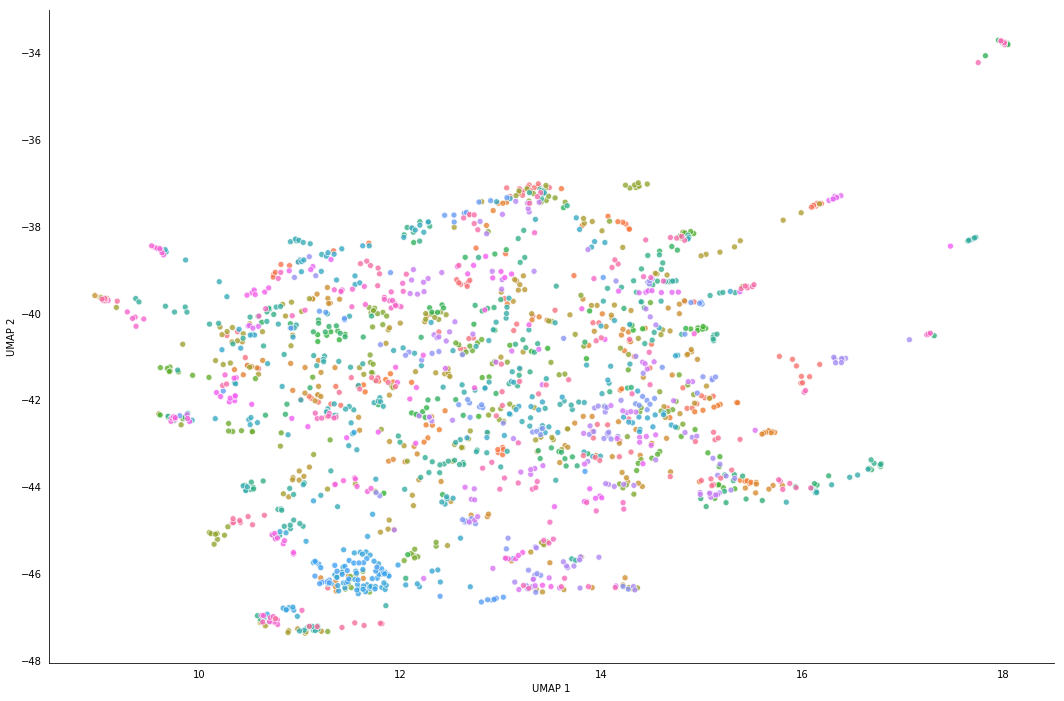

In [421]:
fig, ax = plt.subplots(figsize=(18,12))

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x=u_coords[:, 0].tolist(), y=u_coords[:, 1].tolist(), hue=hue, ax=ax, cmap='viridis', alpha=.8)

plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.tick_params(axis='y', which='both', right=False, left=False)

for pos in ['right','top']:
    plt.gca().spines[pos].set_visible(False)
    
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

#for i, row in plot_text.iterrows():
#    plt.annotate(row.name, (row[0], row[1]))

ax.legend().remove()
#plt.legend(bbox_to_anchor=(.5, -.35), loc=8, ncol=8)

plt.show()

(array([ 1.,  0.,  1.,  4., 10., 10., 27., 48., 56., 90.]),
 array([1018. , 1090.6, 1163.2, 1235.8, 1308.4, 1381. , 1453.6, 1526.2,
        1598.8, 1671.4, 1744. ]),
 <a list of 10 Patch objects>)

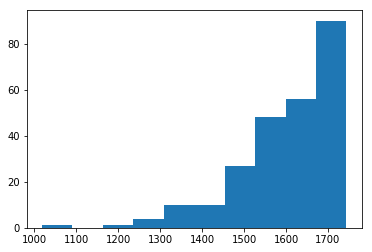

In [305]:
plt.hist(np.sum((merged_df == 0).iloc[:,3:].values, axis=0))

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([1316.33965558, 1316.43965558, 1316.53965558, 1316.63965558,
        1316.73965558, 1316.83965558, 1316.93965558, 1317.03965558,
        1317.13965558, 1317.23965558, 1317.33965558]),
 <a list of 10 Patch objects>)

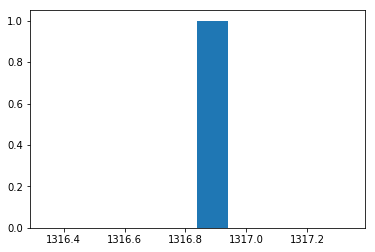

In [311]:
plt.hist(np.sum((merged_df.std(axis=1)), axis=0))

(array([ 16.,   8.,  24.,  64.,  32.,  79., 112., 183., 398., 836.]),
 array([133. , 144.3, 155.6, 166.9, 178.2, 189.5, 200.8, 212.1, 223.4,
        234.7, 246. ]),
 <a list of 10 Patch objects>)

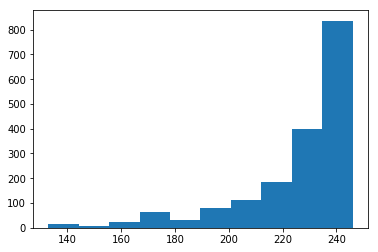

In [304]:
plt.hist(np.sum((merged_df == 0).iloc[:,3:].values, axis=1))

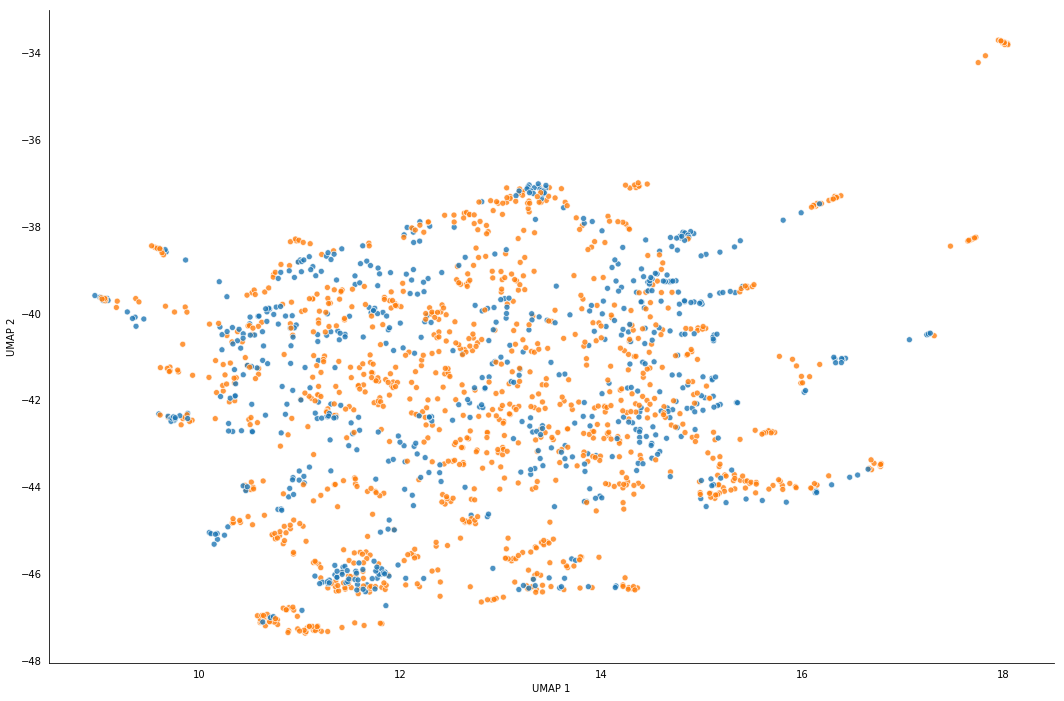

In [434]:
fig, ax = plt.subplots(figsize=(18,12))\

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x=u_coords[:, 0].tolist(), y=u_coords[:, 1].tolist(), hue=growth.isna(), ax=ax, cmap='viridis', alpha=.8)

plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.tick_params(axis='y', which='both', right=False, left=False)

for pos in ['right','top']:
    plt.gca().spines[pos].set_visible(False)
    
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

#for i, row in plot_text.iterrows():
#    plt.annotate(row.name, (row[0], row[1]))

ax.legend().remove()
#plt.legend(bbox_to_anchor=(.5, -.35), loc=8, ncol=8)

plt.show()

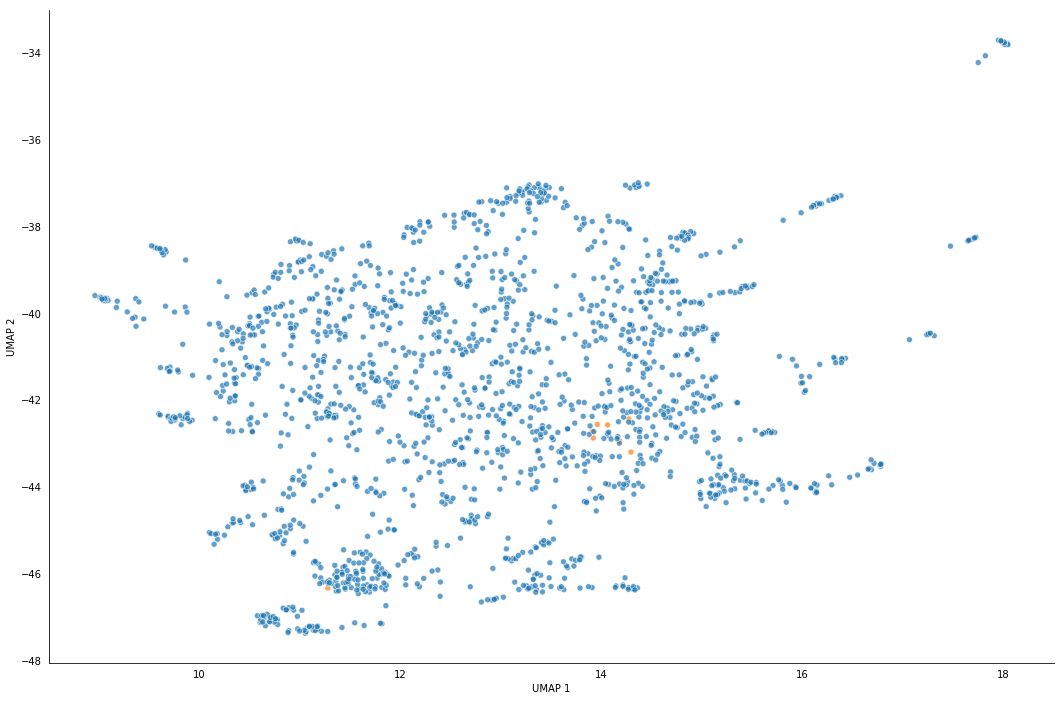

In [427]:
fig, ax = plt.subplots(figsize=(18,12))\

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x=u_coords[:, 0].tolist(), y=u_coords[:, 1].tolist(), hue=merged_df.Drug == "abemaciclib", ax=ax, cmap='viridis', alpha=.7)

plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.tick_params(axis='y', which='both', right=False, left=False)

for pos in ['right','top']:
    plt.gca().spines[pos].set_visible(False)
    
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

#for i, row in plot_text.iterrows():
#    plt.annotate(row.name, (row[0], row[1]))

ax.legend().remove()
#plt.legend(bbox_to_anchor=(.5, -.35), loc=8, ncol=8)

plt.show()

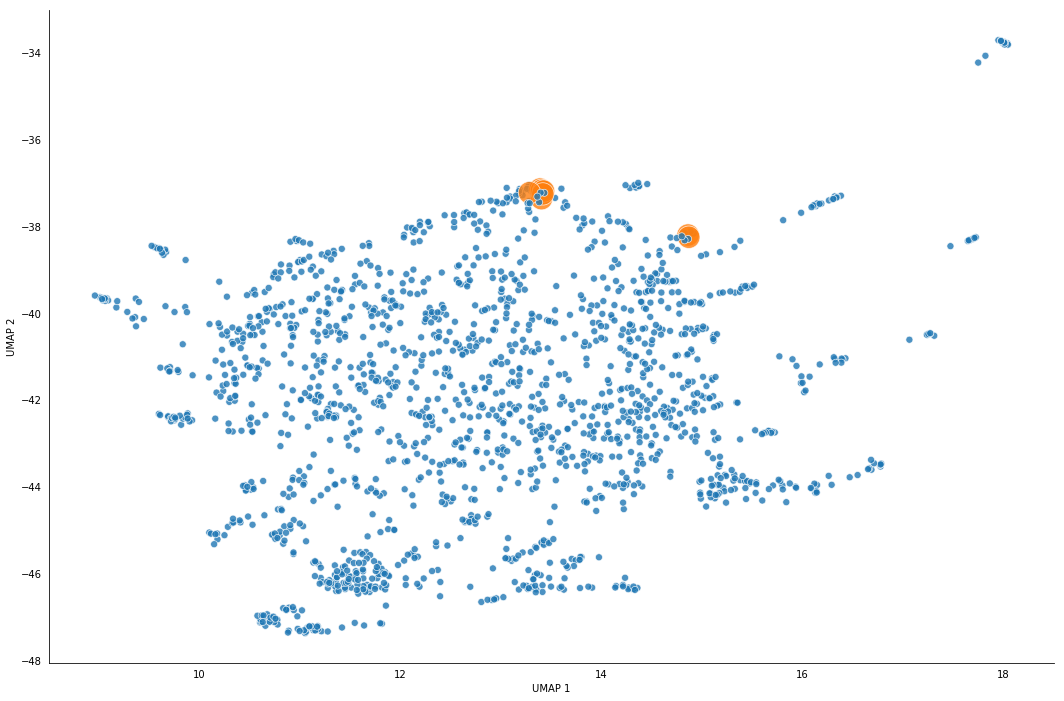

In [432]:
fig, ax = plt.subplots(figsize=(18,12))\

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x=u_coords[:, 0].tolist(), y=u_coords[:, 1].tolist(), hue=merged_df.Drug == "lapatinib", ax=ax, cmap='viridis', alpha=.8, size=merged_df.Drug == "lapatinib", sizes=[50,500])

plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.tick_params(axis='y', which='both', right=False, left=False)

for pos in ['right','top']:
    plt.gca().spines[pos].set_visible(False)
    
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

#for i, row in plot_text.iterrows():
#    plt.annotate(row.name, (row[0], row[1]))

ax.legend().remove()
#plt.legend(bbox_to_anchor=(.5, -.35), loc=8, ncol=8)

plt.show()

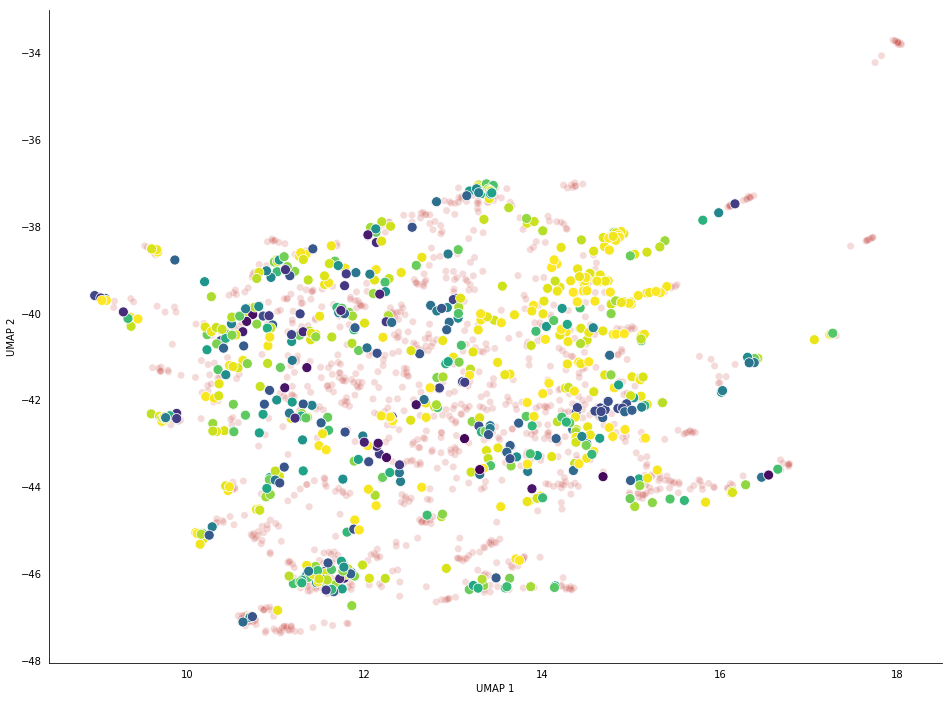

In [486]:
fig, ax = plt.subplots(figsize=(16,12))

#cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
#cmap = sns.vir(dark=.3, light=.8, as_cmap=True)
sns.set_palette('RdBu', n_colors=5)
sns.scatterplot(x=u_coords[growth.isna(), 0].tolist(), y=u_coords[growth.isna(), 1].tolist(), ax=ax, alpha=.2, size=np.random.choice([0,1], np.sum(growth.isna())), sizes=[50, 50])
sns.scatterplot(x=u_coords[~growth.isna(), 0].tolist(), y=u_coords[~growth.isna(), 1].tolist(), hue=growth[~ growth.isna()], ax=ax, palette='viridis', alpha=1, size=np.random.choice([0,1], np.sum(~growth.isna())), sizes=[100, 100])

plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.tick_params(axis='y', which='both', right=False, left=False)

for pos in ['right','top']:
    plt.gca().spines[pos].set_visible(False)
    
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

#for i, row in plot_text.iterrows():
#    plt.annotate(row.name, (row[0], row[1]))

ax.legend().remove()
#plt.legend(bbox_to_anchor=(.5, -.35), loc=8, ncol=8)

plt.show()

In [492]:
coord_df = pd.DataFrame(u_coords, columns=['x', 'y']).join(merged_df[['Drug', 'Concentration', 'Growth']])
coord_df.to_csv('../data/kinotype_coords.tsv', sep='\t')